# Análise preditiva ARIMA

In [246]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_arima = pd.read_csv("GlobalLandTemperaturesByState.csv")
data_arima.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


<AxesSubplot:>

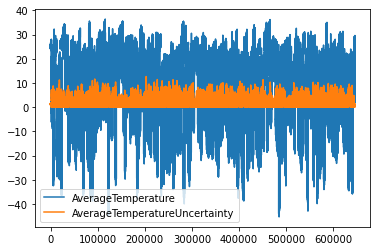

In [247]:
data_arima.plot()

In [248]:
data_arima

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


In [249]:
#verificação de dada máxima, iremos considerar o mínimo como 1800
#print(data_arima['dt'].max())
# Convertendo a coluna "dt" para dados de data
data_arima['dt'] = pd.to_datetime(data_arima['dt'])
#observando análises anteriores foi possível notar que existe uma defasagem nos dados
#anteriores ao ano de 1800
data_arima.drop(data_arima[data_arima['dt']<='1800-01-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['dt']>='2013-09-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['State'] != 'Bahia'].index, inplace=True)
# Extraindo o ano da coluna "dt" para realizarmos uma análise por ano
data_arima["year"] = data_arima["dt"].dt.year

## Aqui começa a análise exploratória de dados para descobrir padrões e tendências, primeiro
## agrupando as temperaturas por ano e estado
dados_previsao = data_arima.groupby(["year","State"], as_index=False).mean()

## Limpeza dos dados utilizando o método .dropna() para remover linhas com valores ausentes 
data_arima.dropna(inplace=True)

dados_previsao.drop('AverageTemperatureUncertainty', axis=1, inplace=True)

dados_previsao.head()


,year,State,AverageTemperature
0,1832,Bahia,23.201917
1,1833,Bahia,23.958250
2,1834,Bahia,23.626250
3,1835,Bahia,22.881333
4,1836,Bahia,23.216417


In [250]:
dados_previsao.drop('State', axis=1, inplace=True)
dados_previsao.drop('year', axis=1, inplace=True)
dados_previsao.dropna()

,AverageTemperature
0,23.201917
1,23.958250
2,23.626250
3,22.881333
4,23.216417
...,...
177,25.190250
178,25.235250
179,24.613917
180,25.336083


In [251]:
msk = (dados_previsao.index < len(dados_previsao)-20)
df_train = dados_previsao[msk].copy()
df_test = dados_previsao[~msk].copy()

c:\Users\leona\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


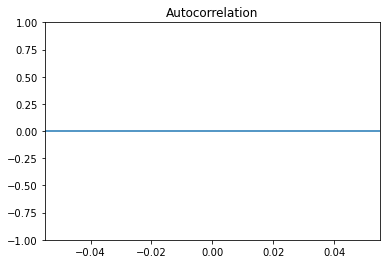

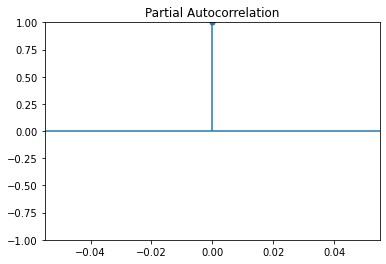

In [252]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [253]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
#print(f'p-value: {adf_test[1]}')

MissingDataError: exog contains inf or nans

<AxesSubplot:>

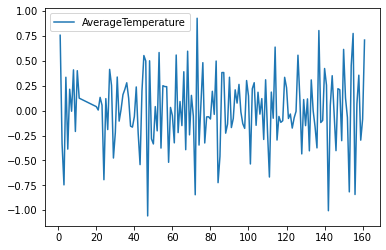

In [254]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


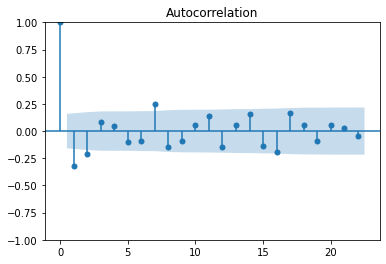

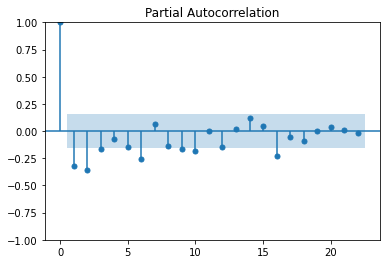

In [255]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [256]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 2.374751513069462e-09


In [257]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dados_previsao, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  182
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -46.751
Date:                Sun, 15 Jan 2023   AIC                            105.501
Time:                        23:23:55   BIC                            124.692
Sample:                             0   HQIC                           113.282
                                - 182                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6033      0.074     -8.196      0.000      -0.748      -0.459
ar.L2         -0.5412      0.087     -6.197      0.000      -0.712      -0.370
ar.L3         -0.2943      0.099     -2.964      0.0

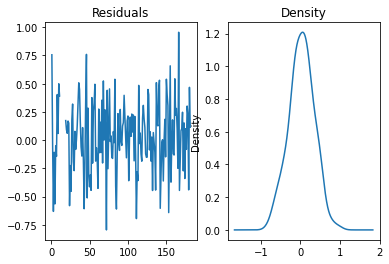

In [258]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

c:\Users\leona\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\leona\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


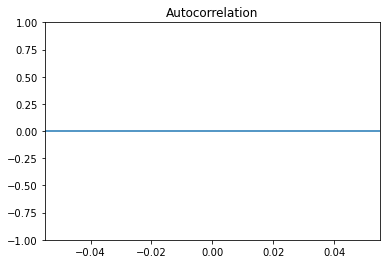

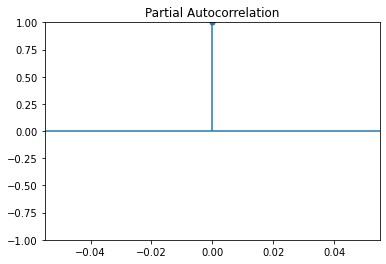

In [259]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<AxesSubplot:>

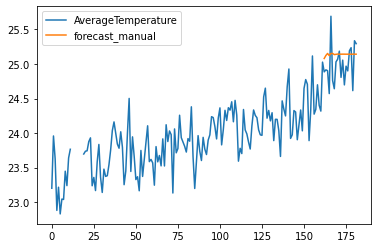

In [261]:
forecast_test = model_fit.forecast(len(df_test))

dados_previsao['forecast_manual'] = [None]*len(df_train) + list(forecast_test)


dados_previsao.plot()